In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

from functools import reduce

import anndata as ad
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import multiprocessing

n_cpu = multiprocessing.cpu_count()

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [5]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


In [6]:
# adata_path = data_dir / "metadata" / f"combined_10_07.h5ad"
adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
adata = sc.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\athena\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
adata.obs.Phenotype.cat.categories 

Index(['B cells', 'Cytotoxic T-cells', 'DZ B-cells', 'Exhausted T-cells',
       'FDCs', 'Follicular CD8+ T-cells', 'Follicular Helper T-cells',
       'GC B-cells', 'Helper T-cells', 'LZ B-cells', 'Plasma Cells',
       'Regulatory T-cells', 'Stromal cells', 'T cells'],
      dtype='object')

In [8]:
old_to_new = {
    'Plasma Cells':'PB/PC',
}
adata.obs['Phenotype'] = (
    adata.obs['Phenotype']
    .apply(lambda x: old_to_new.get(x,x))
    .astype('category')
)

# Spatial analysis

In [9]:
import spatial as sm

In [10]:
# Spatial LDA need centroid info as indivisual obs
adata.obs['X_centroid'] = adata.obsm['spatial'][:,0]
adata.obs['Y_centroid'] = adata.obsm['spatial'][:,1]
adata.obs = adata.obs.reset_index(drop=True)

In [11]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap
heatmap_cmp_r = palettable.cmocean.diverging.Balance_20_r.mpl_colormap

In [12]:
var = 'Phenotype'
tissues = [['LN Donor A', 'LN Donor E'], 
           ['TS Donor A', 'TS Donor E'],
           ['INT Donor B', 'INT Donor E']]

['LN Donor A', 'LN Donor E']
Processing Image: LN Donor A
Processing Image: LN Donor E


C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


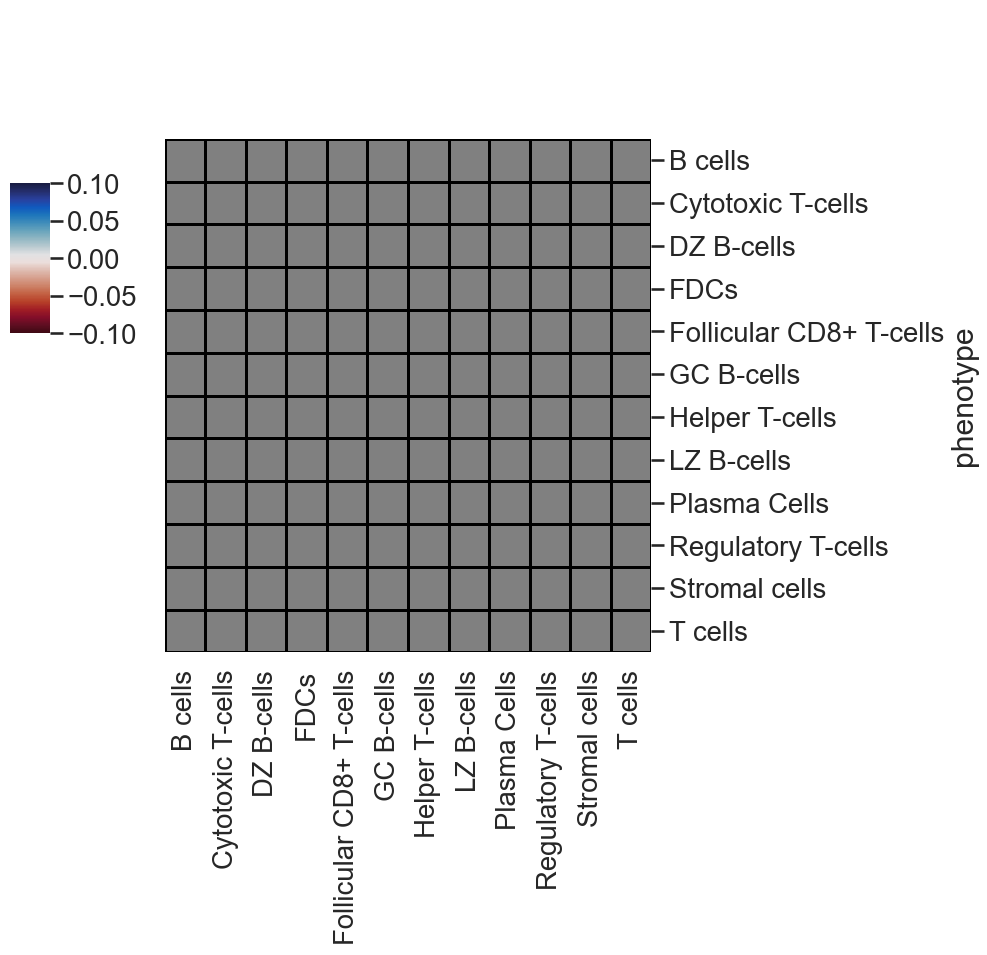

In [20]:
for d in tissues:
    print(d)
    adata_subset = adata[adata.obs.Dataset.isin(d), :]
    counts = adata_subset.obs[var].value_counts()
    low_counts = counts[counts < 500].index.tolist()
    adata_subset = adata_subset[~adata_subset.obs[var].isin(low_counts)]
    
    # Plot interaction p value 
    with sns.plotting_context('talk', font_scale=1.2):
        adata_subset = sm.tl.spatial_distance(adata_subset, x_coordinate='X_centroid', phenotype=var,
                              y_coordinate='Y_centroid', imageid='Dataset')

        sm.pl.spatial_distance(adata_subset,  phenotype=var, imageid='Dataset', heatmap_cmap=heatmap_cmp_r,
                       linewidths=0.75, linecolor='black', cbar_pos=(0.,0.644,0.04, 0.15), log=True)
    break

# Per tissue type

In [ ]:
var = 'Phenotype'
tissues = [['LN Donor A', 'LN Donor E'], 
           ['TS Donor A', 'TS Donor E'],
           ['INT Donor B', 'INT Donor E']]

for d in tissues:
    print(d)
    adata_subset = adata[adata.obs.Dataset.isin(d), :]
    counts = adata_subset.obs[var].value_counts()
    low_counts = counts[counts < 500].index.tolist()
    adata_subset = adata_subset[~adata_subset.obs[var].isin(low_counts)]
    
    # Plot interaction p value 
    with sns.plotting_context('talk', font_scale=1.2):
        adata_subset = sm.tl.spatial_interaction(adata_subset,
                                             method='radius', 
                                             radius=20, 
                                             knn=15,
                                             phenotype=var,
                                             imageid='Dataset',
                                             pval_method='zscore',
                                             x_coordinate='X_centroid',
                                             y_coordinate='Y_centroid')
        
        sm.pl.spatial_interaction(adata_subset, 
                          summarize_plot=True, 
                          binary_view=False,
                          row_cluster=False, 
                          linewidths=0.75, 
                          linecolor='black',
                          cmap=heatmap_cmp,
                          p_val=0.05,
                          nonsig_color='k',
                          cbar_pos=(0.,0.644,0.04, 0.15)    
                         )
        sm.tl.spatial_distance(adata_subset, x_coordinate='X_centroid', phenotype=var,
                              y_coordinate='Y_centroid', imageid='Dataset')

        sm.pl.spatial_distance(adata_subset,  phenotype=var, imageid='Dataset', heatmap_cmap=heatmap_cmp_r,
                       linewidths=0.75, linecolor='black', cbar_pos=(0.,0.644,0.04, 0.15), log=True)
    plt.show()


['TS Donor A', 'TS Donor E']
Processing Image: ['TS Donor A']
Categories (1, object): ['TS Donor A']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations


# Individual Tissue 

LN Donor A
Processing Image: ['LN Donor A']
Categories (1, object): ['LN Donor A']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


Y:\coskun-lab\Thomas\Leap\src\spatial\tools\_spatial_interaction.py:443: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[label] = df_merged
C:\Users\thu71\Anaconda3\envs\athena\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing Image: LN Donor A


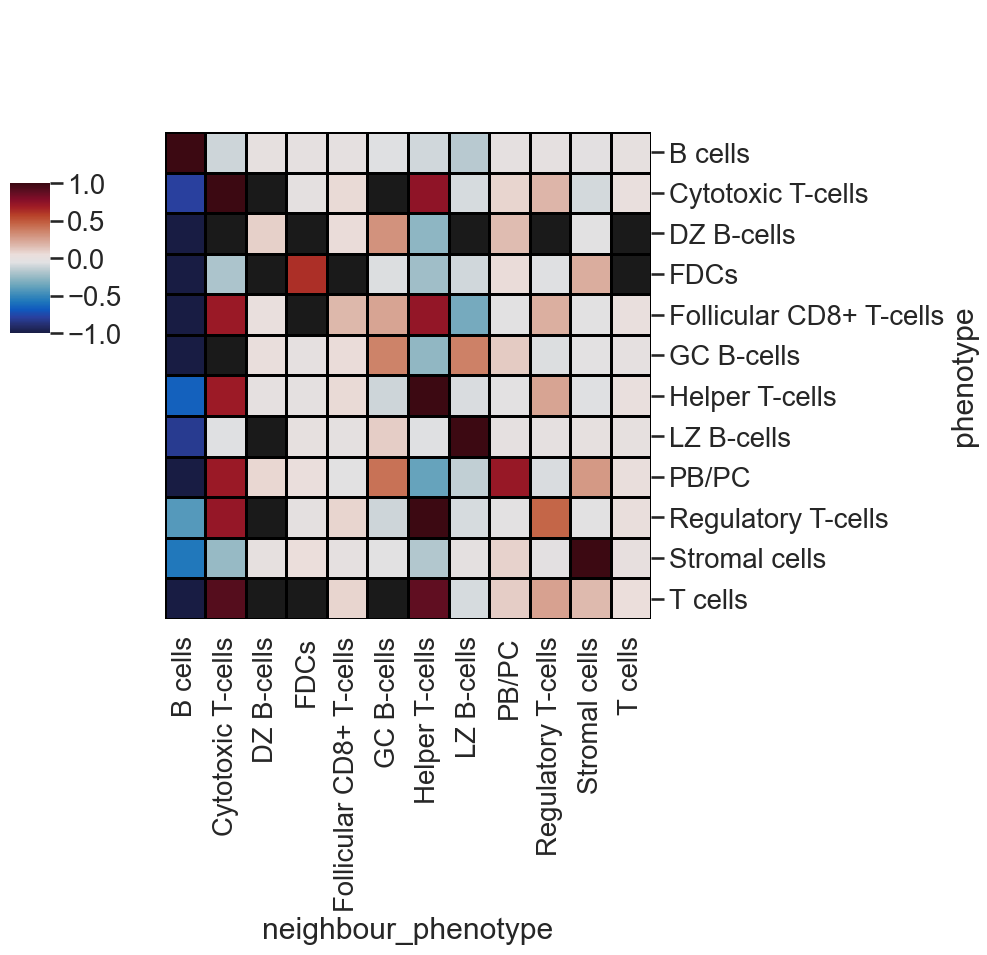

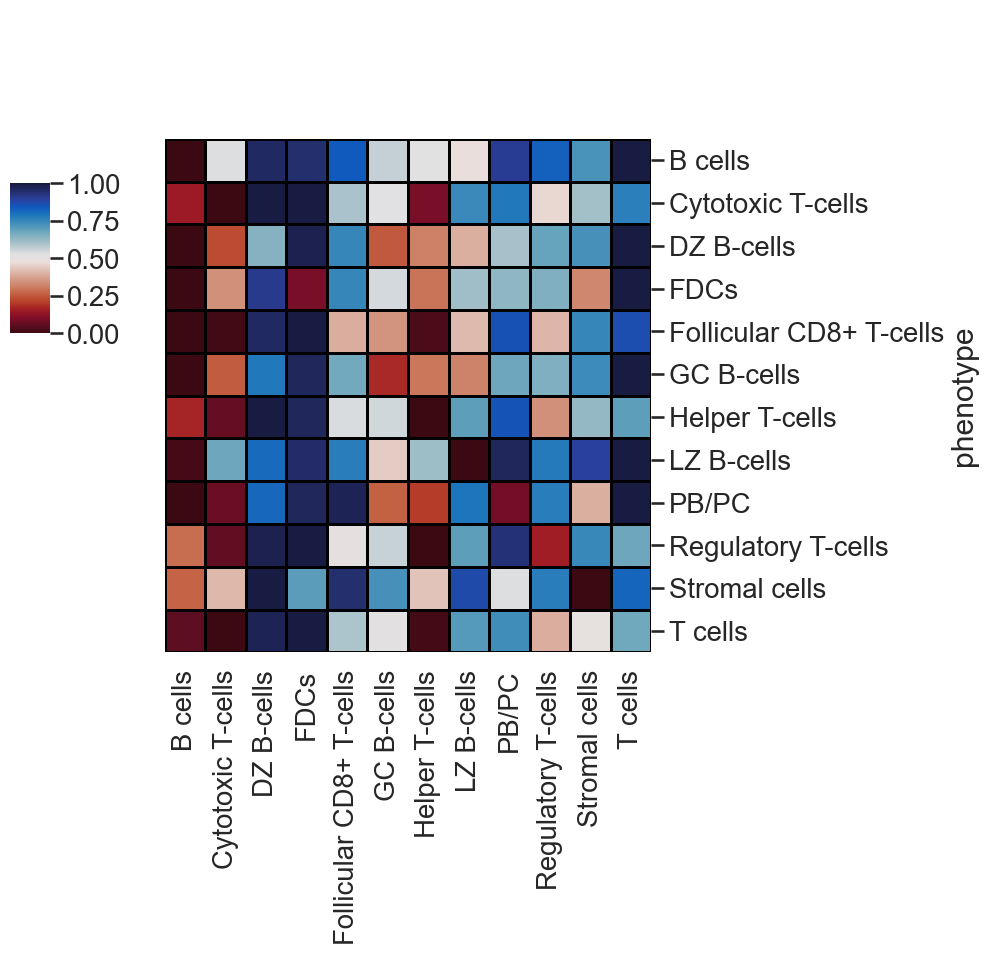

LN Donor E
Processing Image: ['LN Donor E']
Categories (1, object): ['LN Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


Y:\coskun-lab\Thomas\Leap\src\spatial\tools\_spatial_interaction.py:443: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[label] = df_merged
C:\Users\thu71\Anaconda3\envs\athena\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing Image: LN Donor E


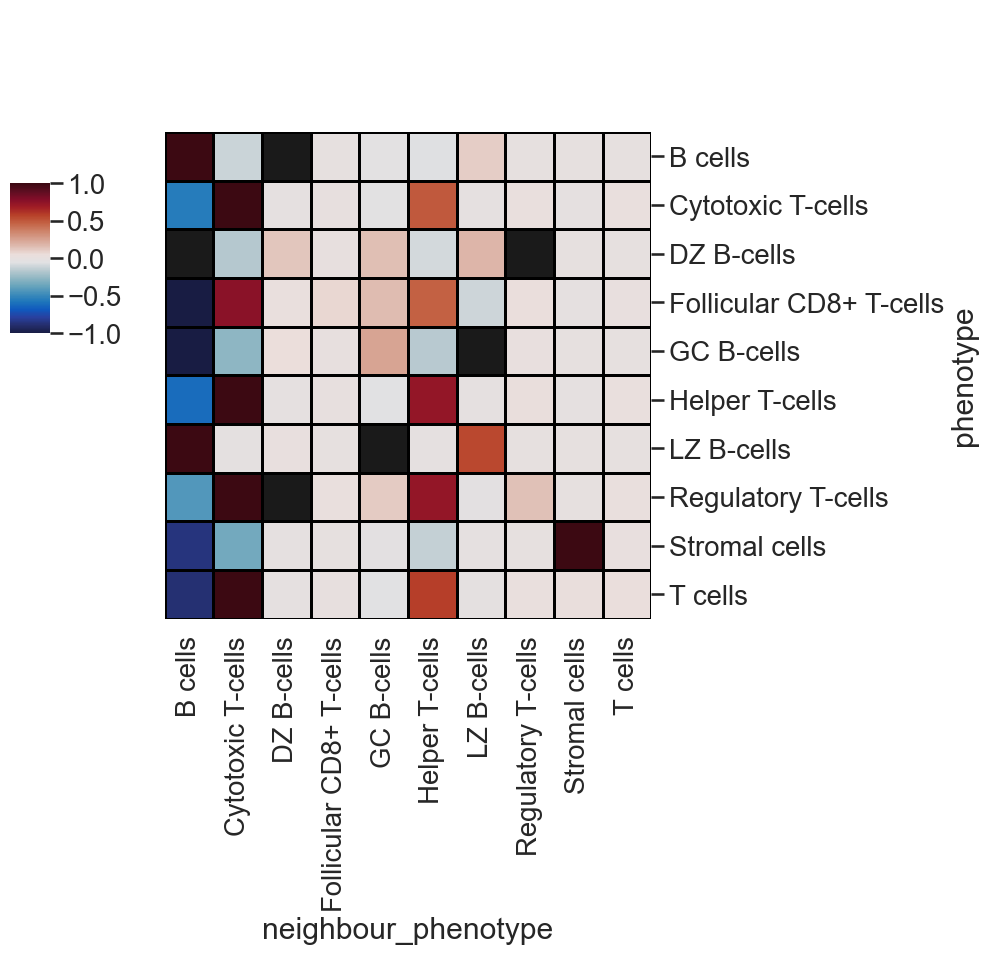

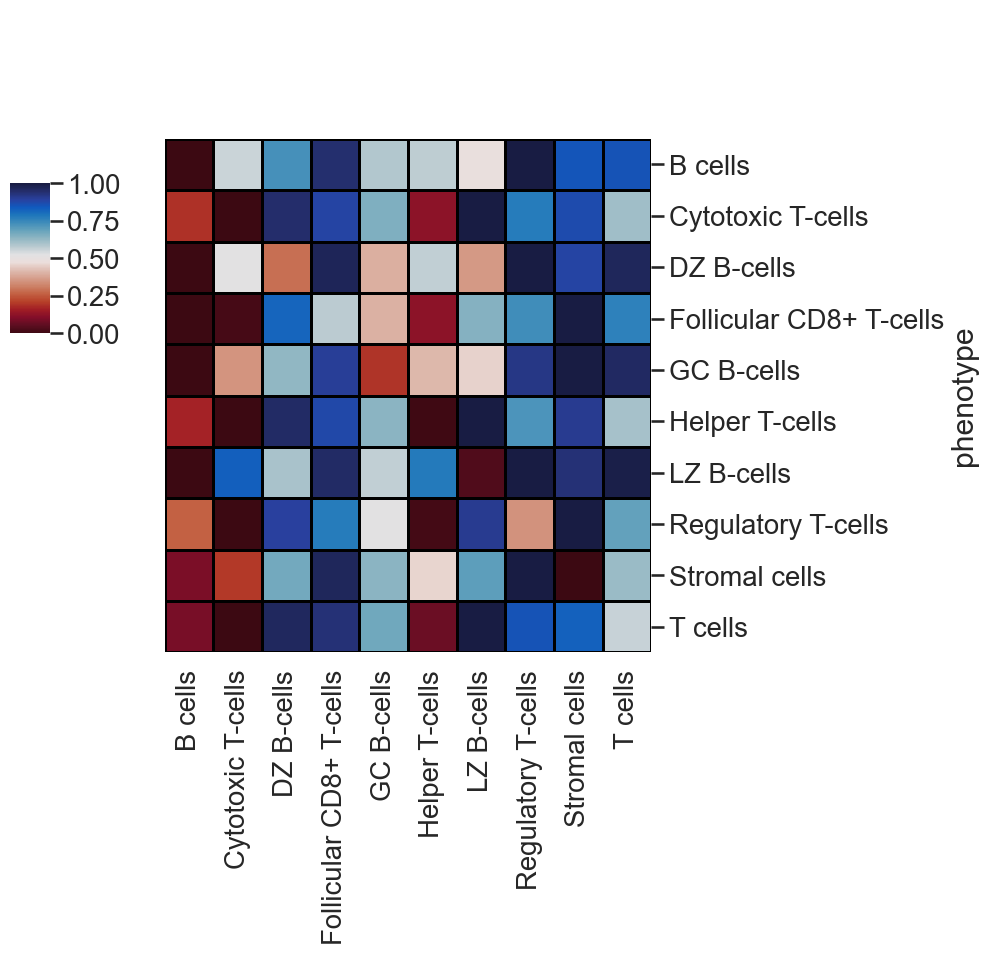

INT Donor B
Processing Image: ['INT Donor B']
Categories (1, object): ['INT Donor B']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


Y:\coskun-lab\Thomas\Leap\src\spatial\tools\_spatial_interaction.py:443: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[label] = df_merged
C:\Users\thu71\Anaconda3\envs\athena\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing Image: INT Donor B


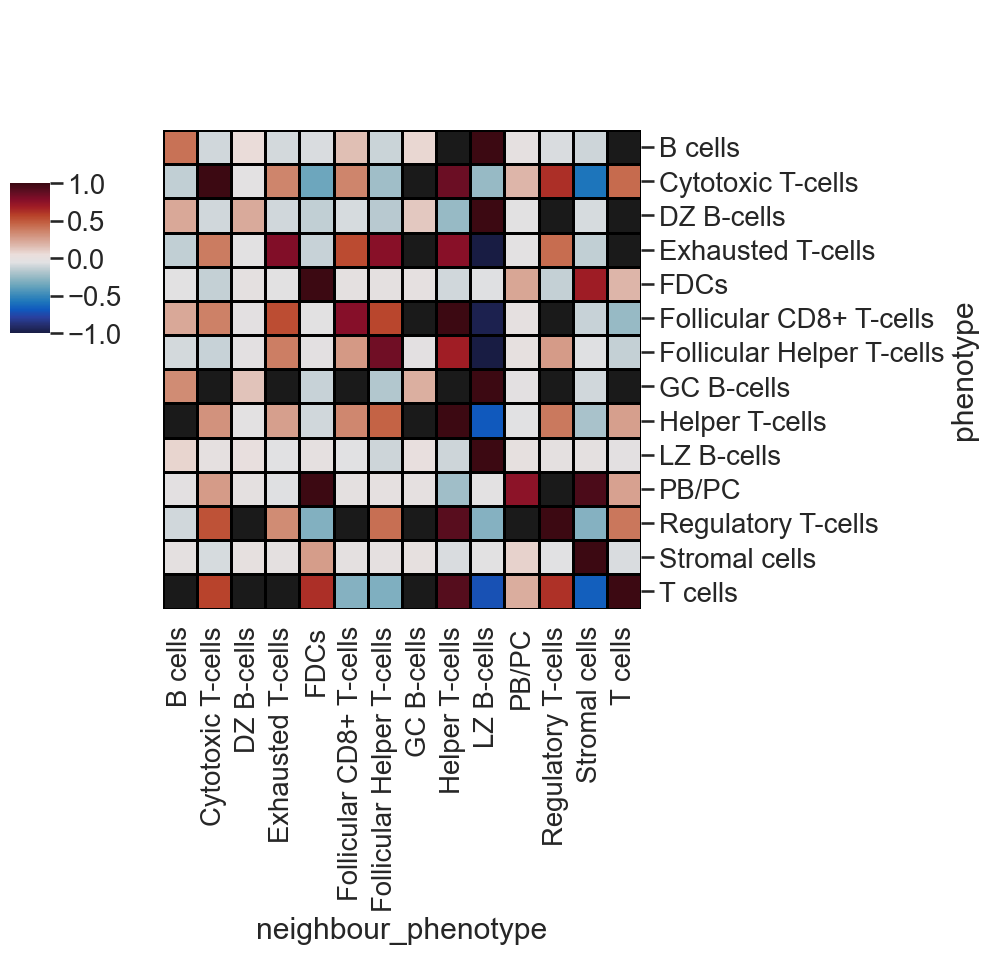

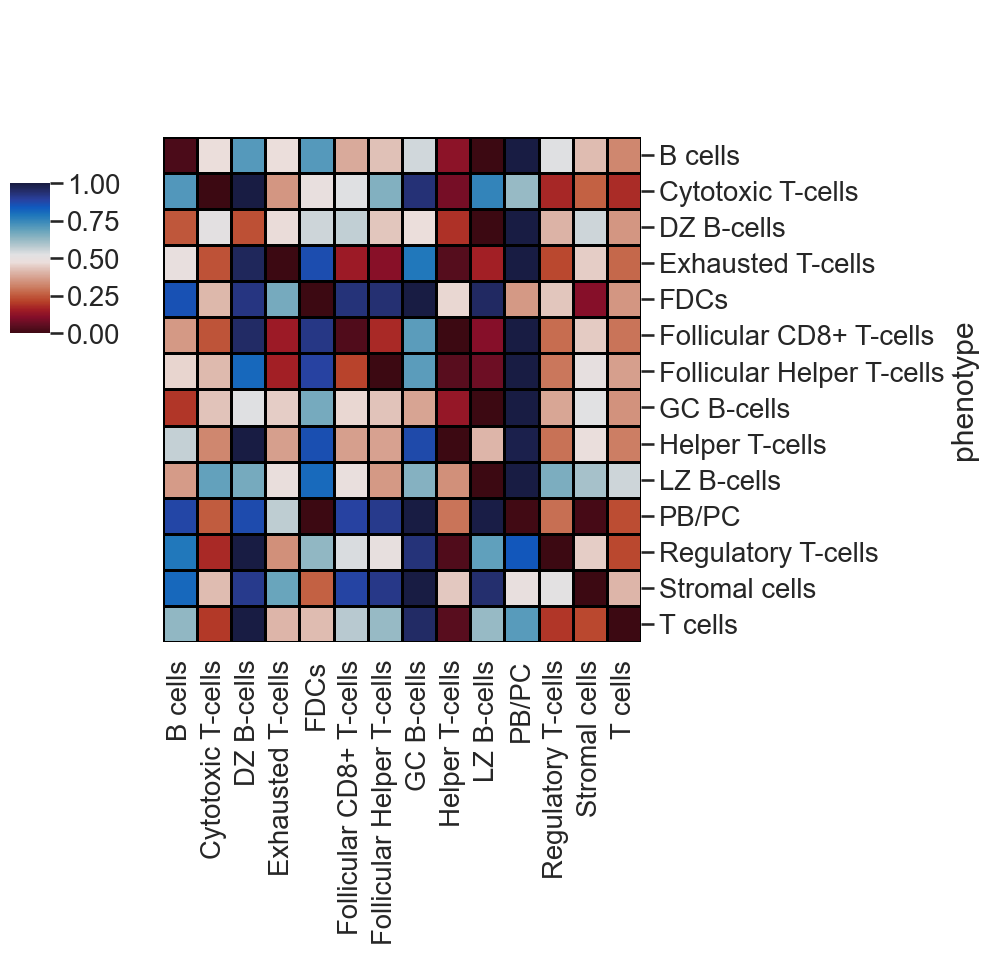

INT Donor E
Processing Image: ['INT Donor E']
Categories (1, object): ['INT Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


Y:\coskun-lab\Thomas\Leap\src\spatial\tools\_spatial_interaction.py:443: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[label] = df_merged
C:\Users\thu71\Anaconda3\envs\athena\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing Image: INT Donor E


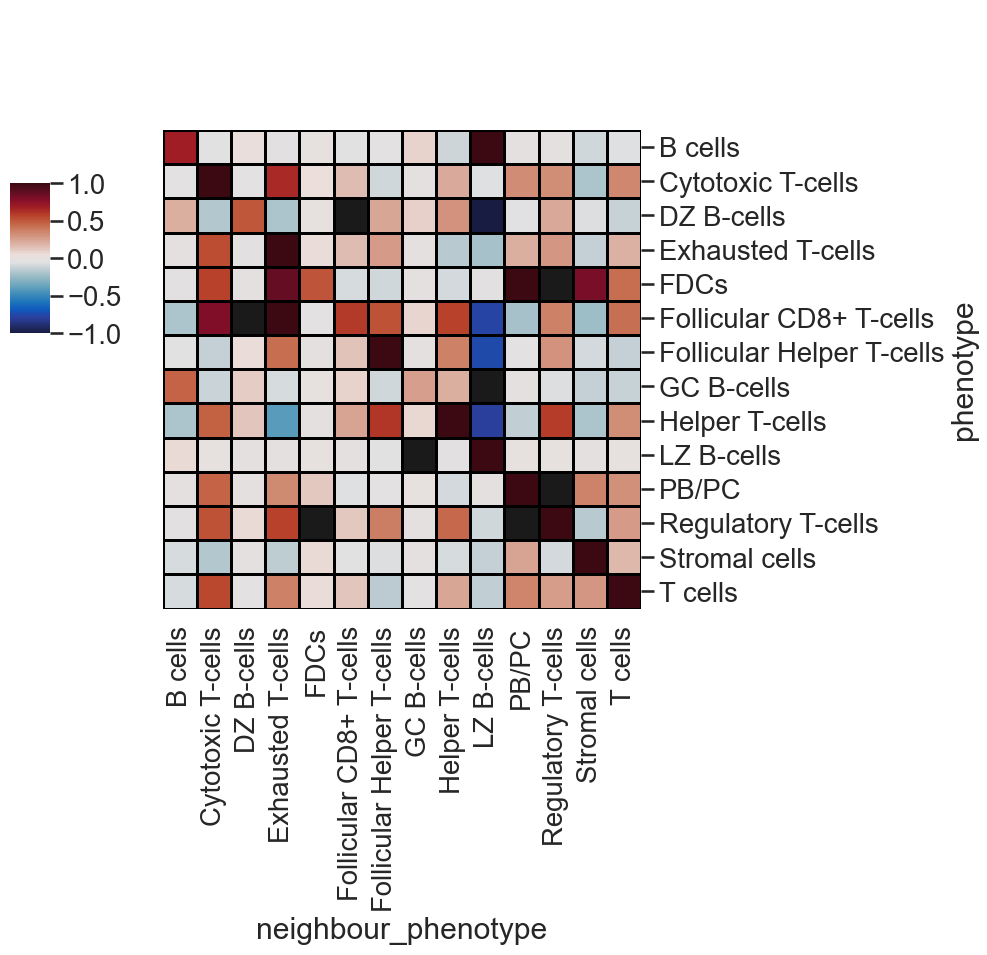

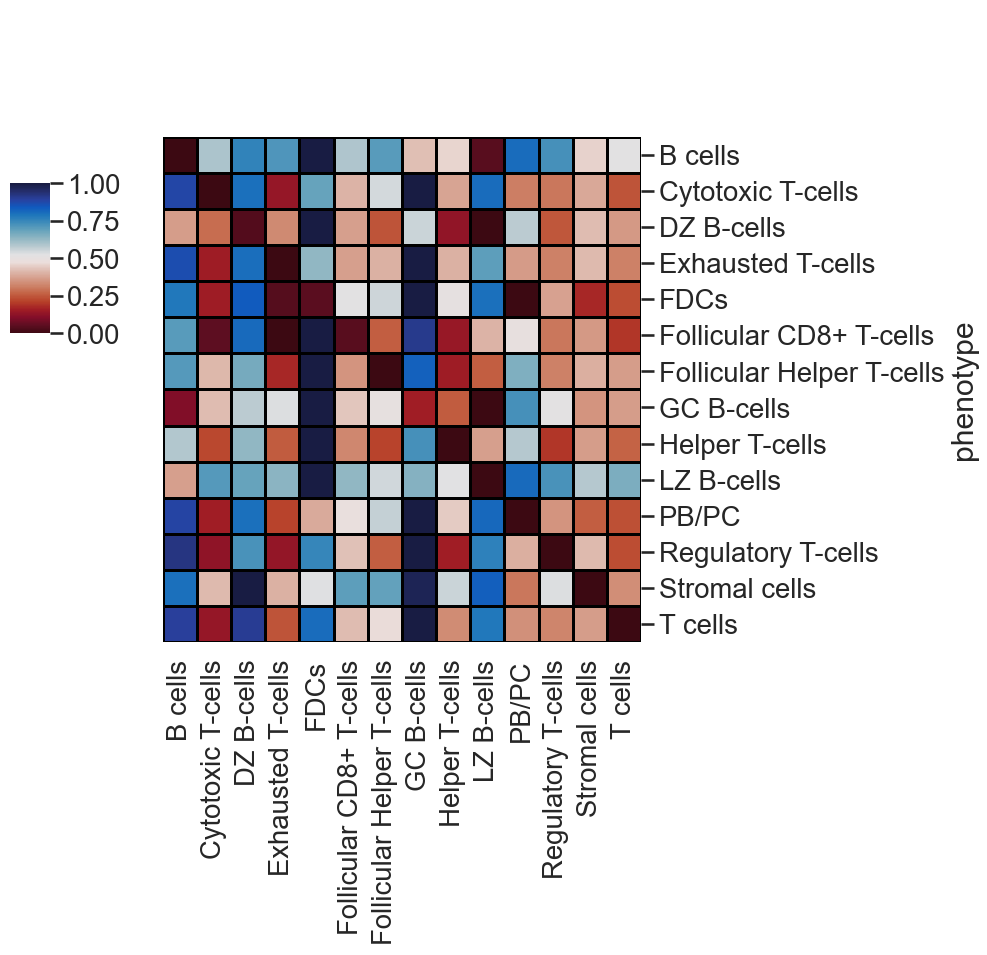

TS Donor A
Processing Image: ['TS Donor A']
Categories (1, object): ['TS Donor A']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


Y:\coskun-lab\Thomas\Leap\src\spatial\tools\_spatial_interaction.py:443: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[label] = df_merged
C:\Users\thu71\Anaconda3\envs\athena\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing Image: TS Donor A


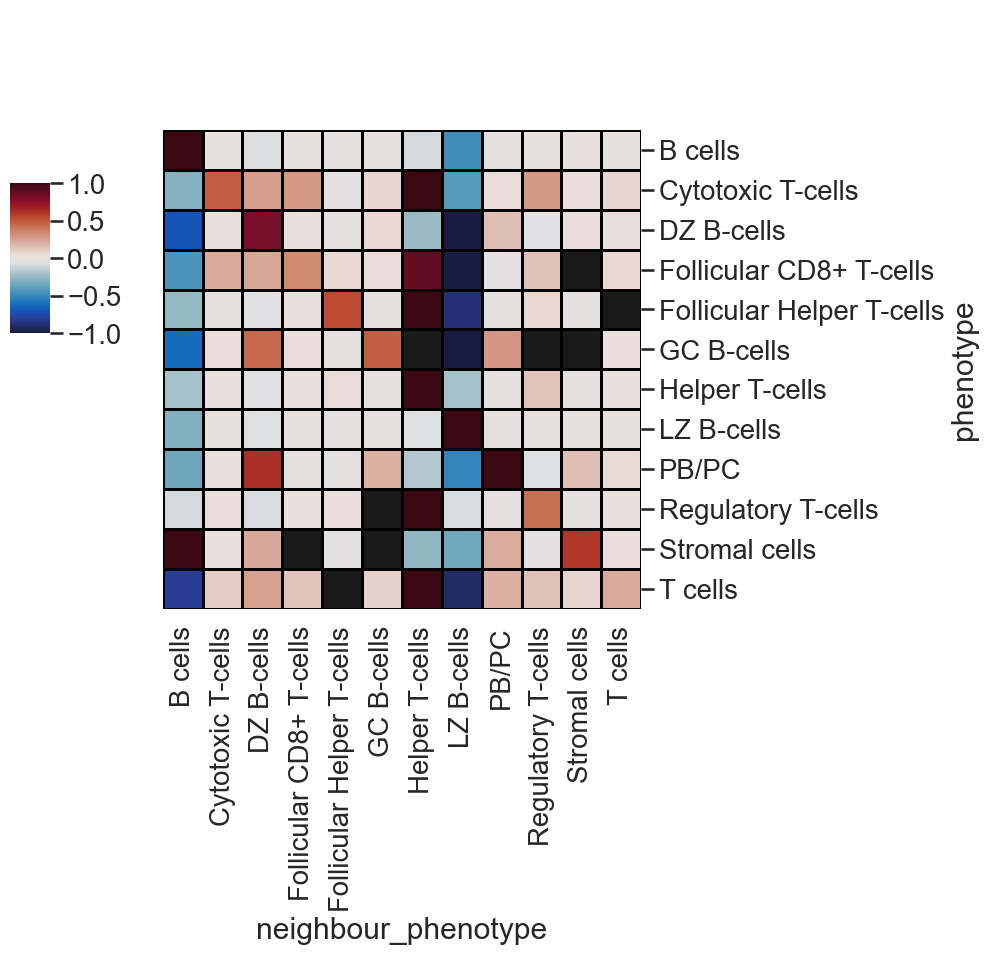

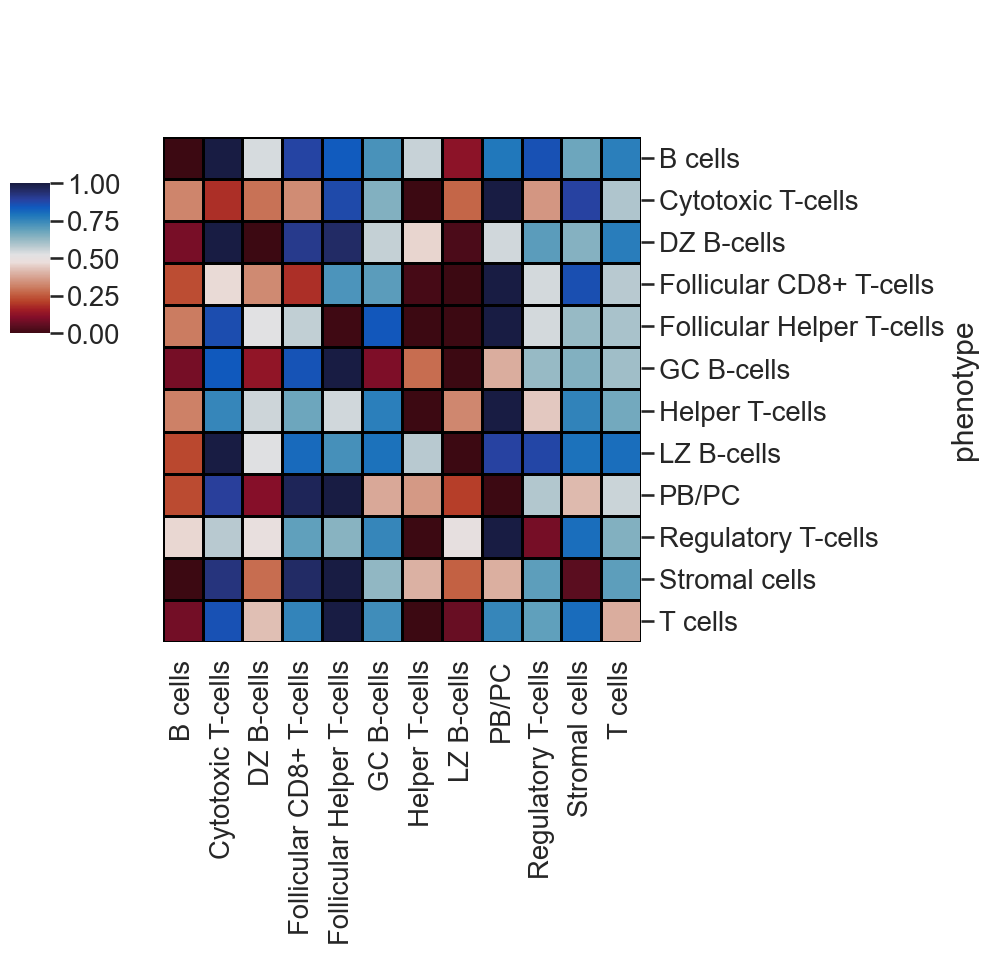

TS Donor E
Processing Image: ['TS Donor E']
Categories (1, object): ['TS Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


Y:\coskun-lab\Thomas\Leap\src\spatial\tools\_spatial_interaction.py:443: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[label] = df_merged
C:\Users\thu71\Anaconda3\envs\athena\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Processing Image: TS Donor E


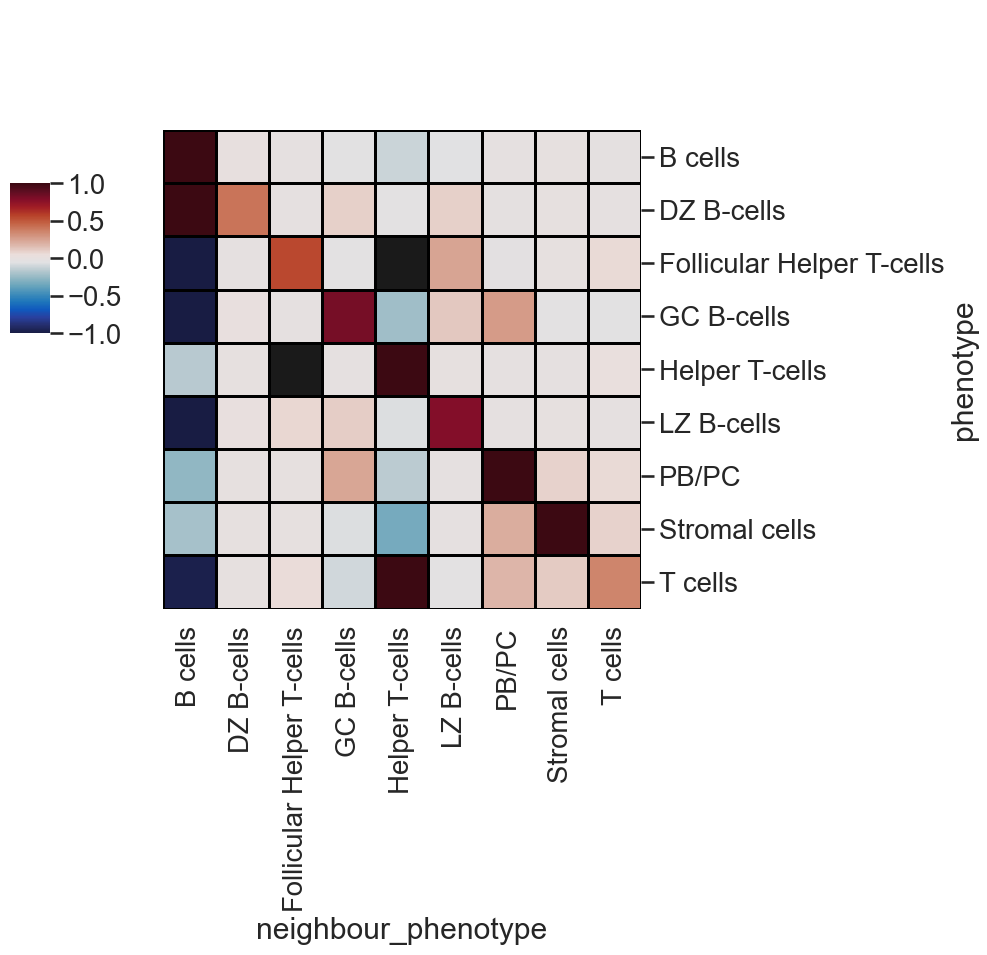

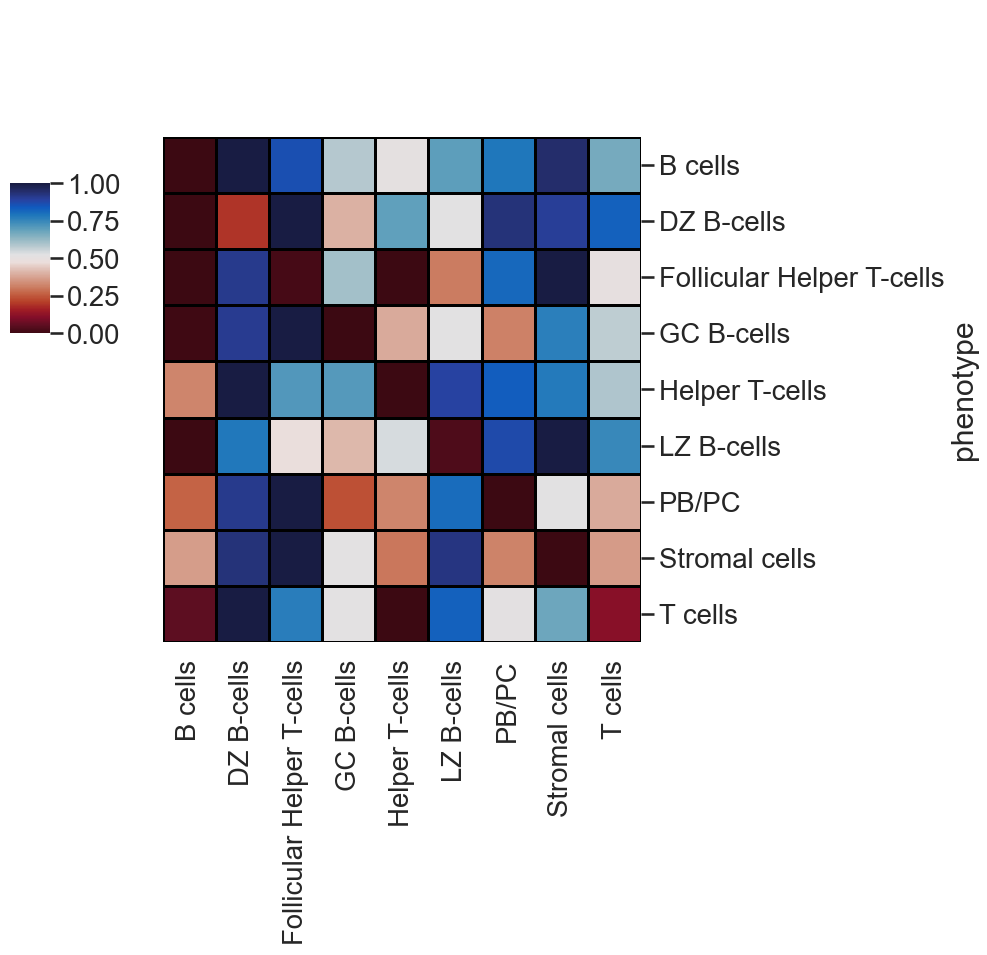

In [13]:
var = 'Phenotype'

for d in donors:
    print(d)
    adata_subset = adata[adata.obs.Dataset == d, :]
    counts = adata_subset.obs[var].value_counts()
    low_counts = counts[counts < 500].index.tolist()
    adata_subset = adata_subset[~adata_subset.obs[var].isin(low_counts)]
    
    # Plot interaction p value 
    with sns.plotting_context('talk', font_scale=1.2):
        adata_subset = sm.tl.spatial_interaction(adata_subset,
                                             method='radius', 
                                             radius=20, 
                                             knn=15,
                                             phenotype=var,
                                             imageid='Dataset',
                                             x_coordinate='X_centroid',
                                             y_coordinate='Y_centroid')
        
        sm.pl.spatial_interaction(adata_subset, 
                          summarize_plot=True, 
                          binary_view=False,
                          row_cluster=False, 
                          linewidths=0.75, 
                          linecolor='black',
                          cmap=heatmap_cmp,
                          p_val=0.0005,
                          nonsig_color='k',
                          cbar_pos=(0.,0.644,0.04, 0.15)    
                         )
        sm.tl.spatial_distance(adata_subset, x_coordinate='X_centroid', phenotype=var,
                              y_coordinate='Y_centroid', imageid='Dataset')

        sm.pl.spatial_distance(adata_subset,  phenotype=var, imageid='Dataset', heatmap_cmap=heatmap_cmp_r,
                       linewidths=0.75, linecolor='black', cbar_pos=(0.,0.644,0.04, 0.15), log=True)
    plt.show()


# Compare all tissues interaction 

In [11]:
# Pass the ROI's as different images
adata = sm.tl.spatial_interaction(adata, 
                                 method='radius', 
                                 radius=20, 
                                 knn=15,
                                 phenotype=var,
                                 imageid='Dataset',
                                 x_coordinate='X_centroid',
                                 y_coordinate='Y_centroid',
                                 label='spatial_interaction_all'
                                 )



Processing Image: ['LN Donor A']
Categories (1, object): ['LN Donor A']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['LN Donor E']
Categories (1, object): ['LN Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['INT Donor B']
Categories (1, object): ['INT Donor B']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['INT Donor E']
Categories (1, object): ['INT Donor E']
Identifying neighbours within 20 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: ['TS Donor A']
Categories (1, object): ['TS Donor A']
Identifying neighbours withi

In [12]:
var = 'Phenotype'

sm.tl.spatial_distance(adata, x_coordinate='X_centroid', phenotype=var,
                                      y_coordinate='Y_centroid', imageid='Dataset')


Processing Image: LN Donor A
Processing Image: LN Donor E
Processing Image: INT Donor B
Processing Image: INT Donor E
Processing Image: TS Donor A
Processing Image: TS Donor E


AnnData object with n_obs × n_vars = 899921 × 15
    obs: 'Donor', 'Phenotype', 'ROI', 'Cell_label', 'index', 'Dataset', 'X_centroid', 'Y_centroid'
    uns: 'Dataset_colors', 'Phenotype_colors', 'dendrogram_Phenotype', 'spatial_interaction_all', 'spatial_distance'
    obsm: 'X_scanorama', 'X_tsne', 'spatial'

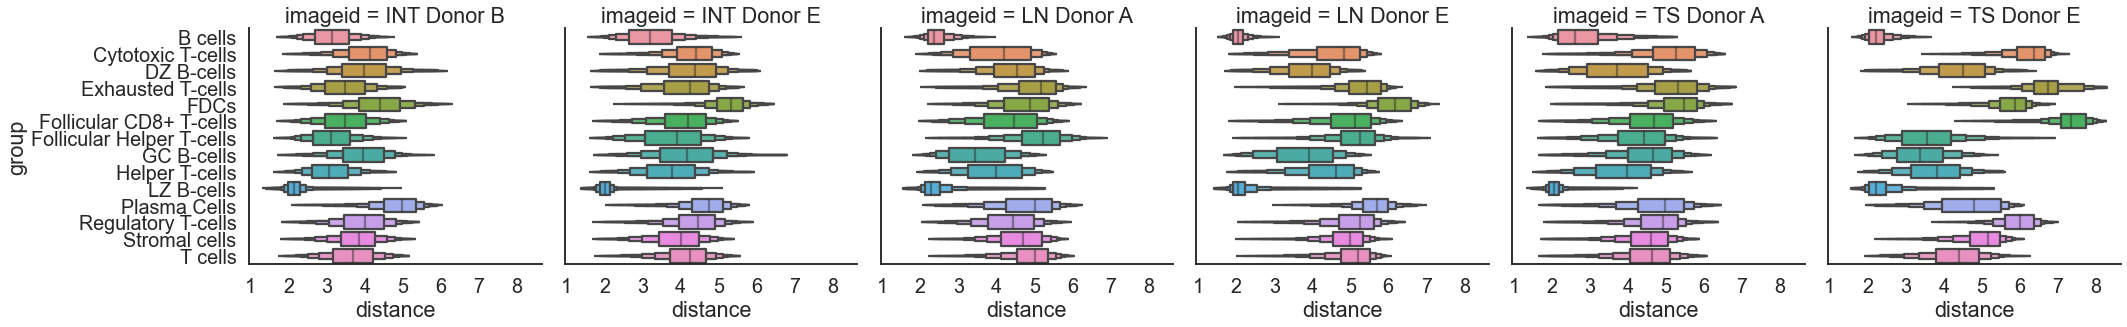

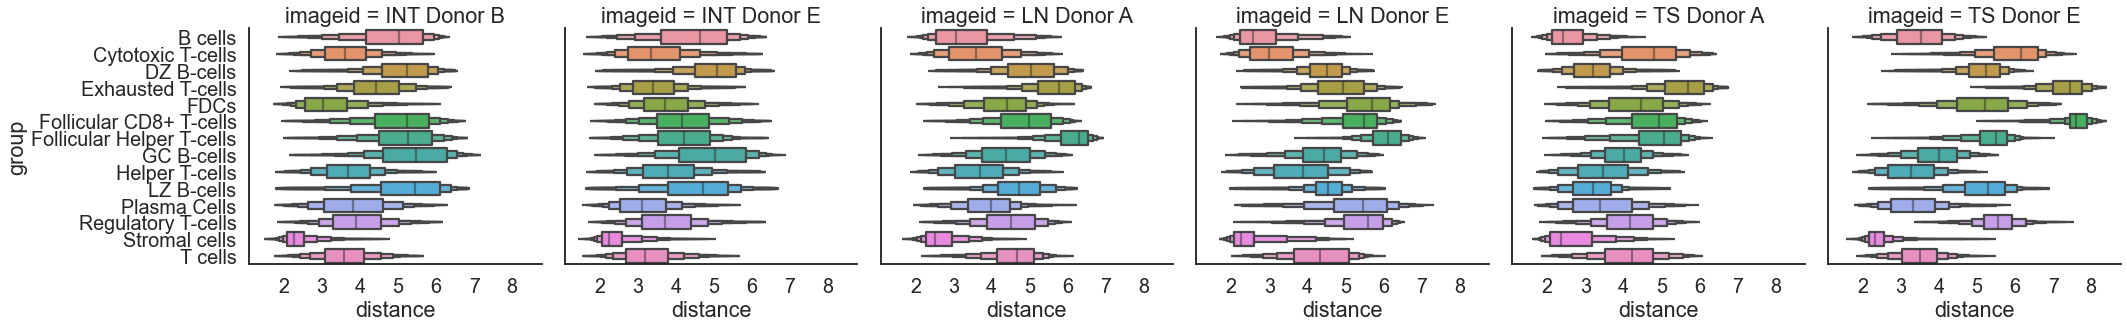

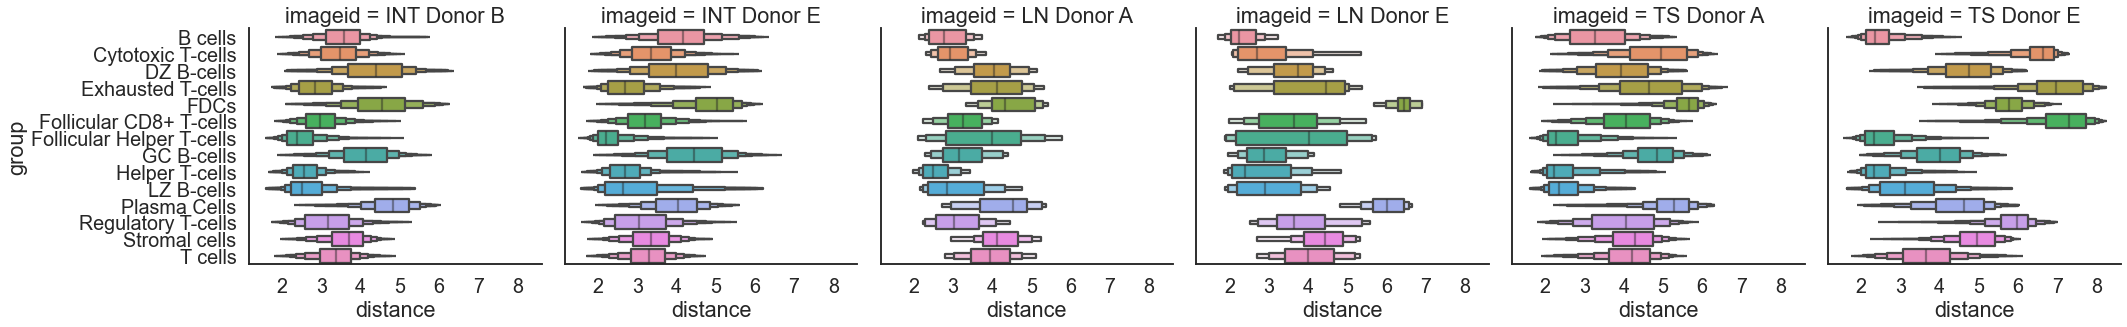

In [13]:
sns.set_style('white')
with sns.plotting_context('talk', font_scale=1.2):
    sm.pl.spatial_distance(adata, method='numeric', phenotype='Phenotype', 
                       imageid='Dataset', distance_from='LZ B-cells', log=True, showfliers=False)
    sm.pl.spatial_distance(adata, method='numeric', phenotype='Phenotype', 
                       imageid='Dataset', distance_from='Stromal cells', log=True, showfliers=False)
    sm.pl.spatial_distance(adata, method='numeric', phenotype='Phenotype', 
                       imageid='Dataset', distance_from='Follicular Helper T-cells', log=True, showfliers=False)
    

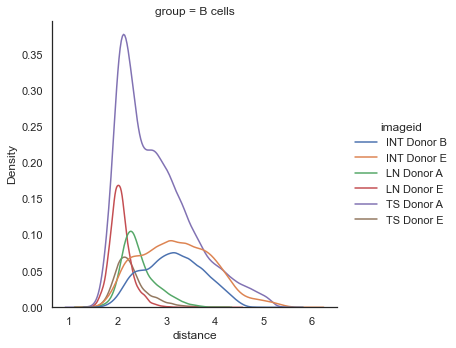

In [14]:
sm.pl.spatial_distance (adata, phenotype='Phenotype', method='distribution', distance_from='LZ B-cells',distance_to ='B cells', imageid='Dataset', log=True)

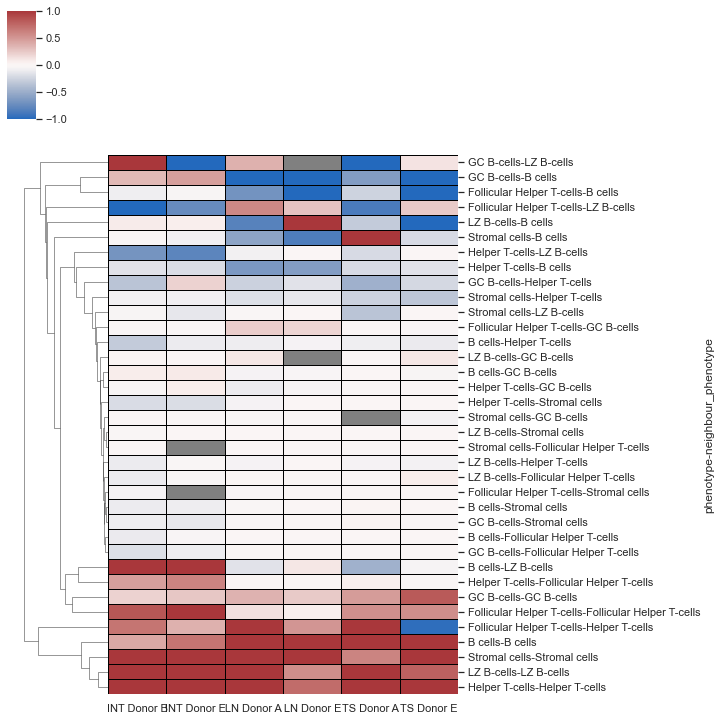

In [15]:
subset_phenotype = ['B cells',  'GC B-cells', 'LZ B-cells', 'Stromal cells', 'Follicular Helper T-cells', 'Helper T-cells']

sm.pl.spatial_interaction(adata, 
                          summarize_plot=False, 
                          spatial_interaction='spatial_interaction_all',
                          subset_phenotype=subset_phenotype , subset_neighbour_phenotype=subset_phenotype ,
                          yticklabels=True,
                          row_cluster=True, linewidths=0.75, linecolor='black', cbar_pos=(0.,0.844,0.04, 0.15)  )

# Proximity score